# Sheet 6

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# 1) Top tagging with CNNs

In [ ]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

In [12]:
# load data
X_train = np.load( "../../sheet06_data/x_train_short.npy")
y_train = np.load( "../../sheet06_data/y_train_short.npy")
X_test = np.load( "../../sheet06_data/x_test_short.npy")
y_test = np.load( "../../sheet06_data/y_test_short.npy")
X_val = np.load( "../../sheet06_data/x_val_short.npy")
y_val = np.load( "../../sheet06_data/y_val_short.npy")

# shape: (events, particles, 4-momenta)
# 4-momenta are ordered as (E, px, py, pz)
# y are the labels (1 for signal=top jet, 0 for background=QCD jet)
print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


(a)

In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [5]:
# needs roughly 3GB of RAM in orig_image
# reduce the number of events in the dataset if needed
z_train = constit_to_img( X_train, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )

# save data 
np.save('../../sheet06_data/z_train', z_train)
np.save('../../sheet06_data/z_test', z_test)
np.save('../../sheet06_data/z_val', z_val)

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


In [7]:
# load processed data
z_train = np.load('../../sheet06_data/z_train.npy')
z_test = np.load('../../sheet06_data/z_test.npy')
z_val = np.load('../../sheet06_data/z_val.npy')

number of 0 events 14960


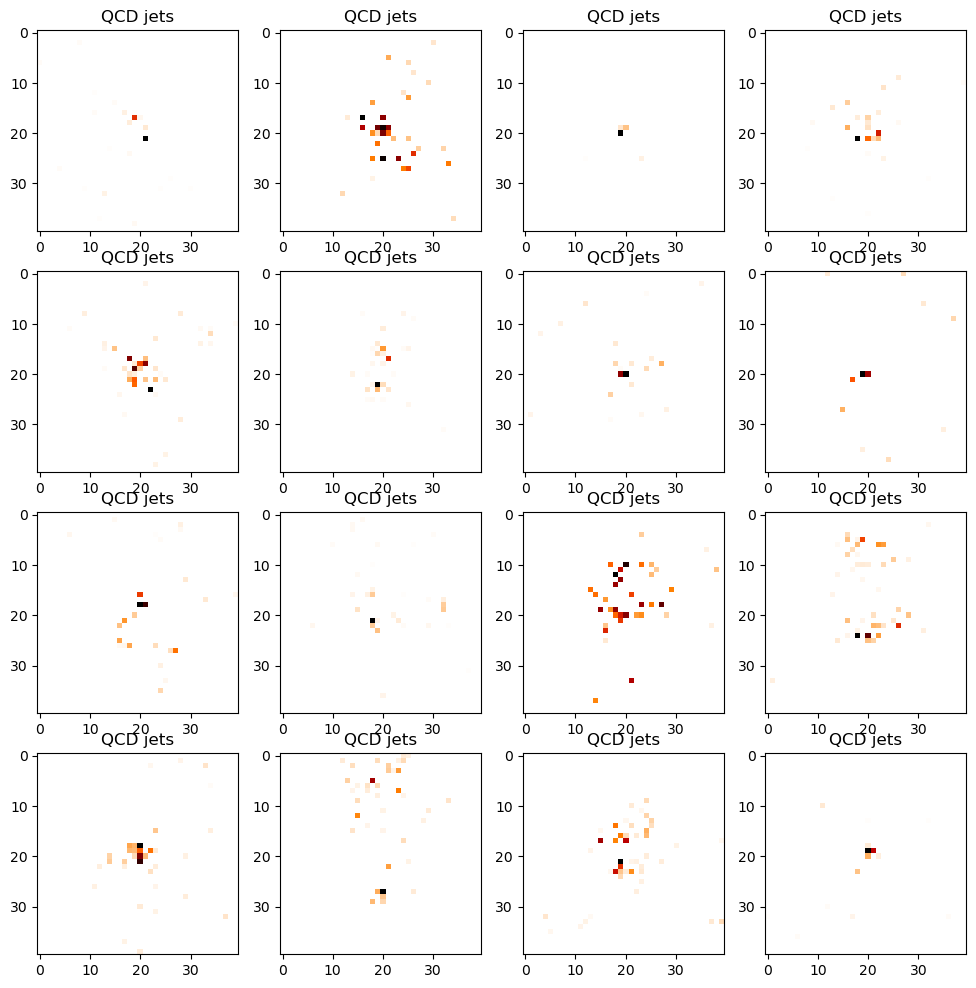

In [14]:
# TODO: Plot image of a top and QCD jet
# Use cmap='gist_heat_r' for nice visualization

# seperate event 0
z_train0 = z_train[y_train == 0]
print('number of 0 events', len(z_train0))


plt.figure(figsize=(12,12))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(z_train0[500 + i,0,:,:], cmap='gist_heat_r')
    plt.title('QCD jets')

number of 1 events 14960


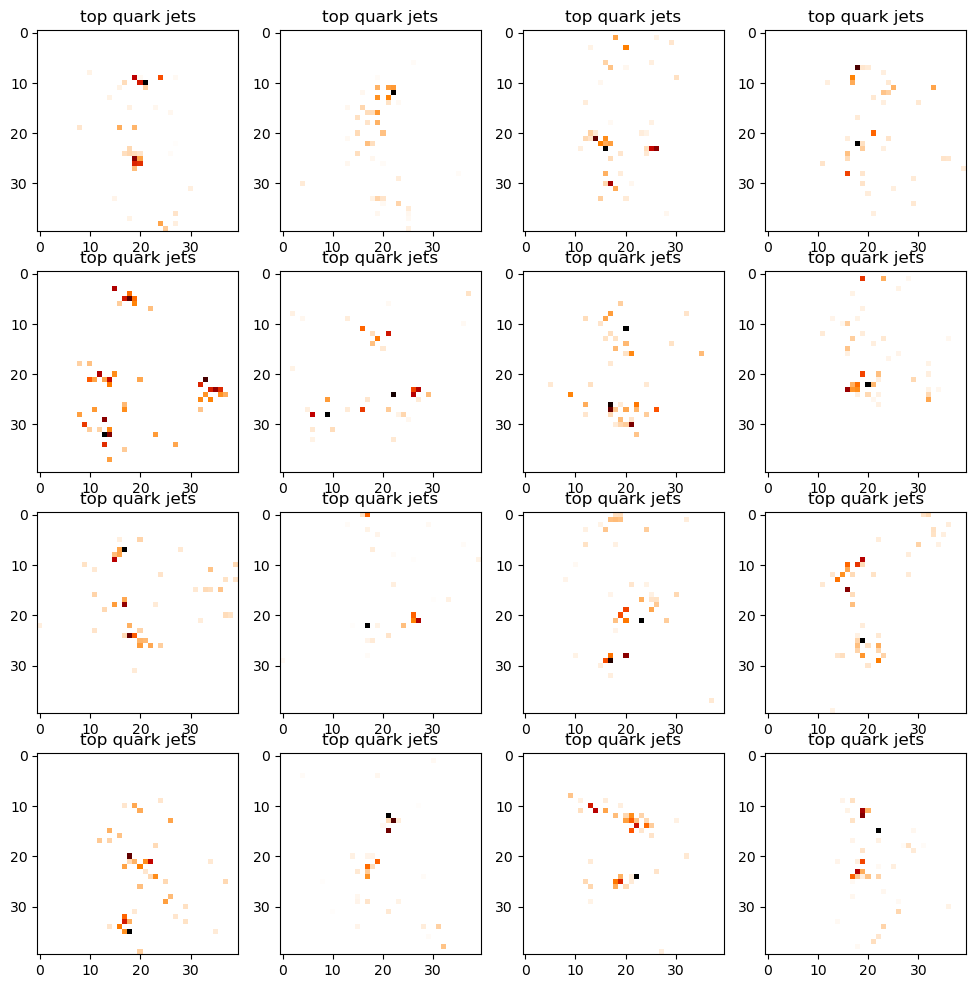

In [16]:
# plot 1 events
z_train1 = z_train[y_train == 1]
print('number of 1 events', len(z_train0))


plt.figure(figsize=(12,12))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(z_train1[500 + i,0,:,:], cmap='gist_heat_r')
    plt.title('top quark jets')

Text(0.5, 1.0, 'Mean top quark jets')

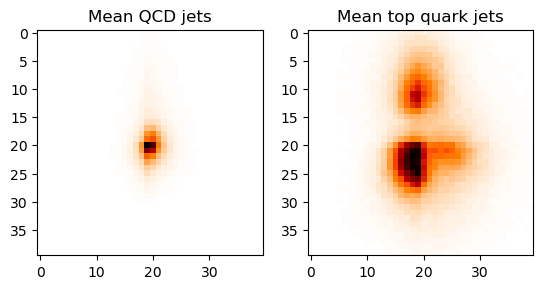

In [17]:
# TODO: Plot image of the mean top and the mean QCD jet
# by averaging over all the respective images in the dataset

z_avg0 = z_train0.mean(axis=0)
z_avg1 = z_train1.mean(axis=0)

plt.subplot(1,2,1)
plt.imshow(z_avg0[0], cmap='gist_heat_r')
plt.title('Mean QCD jets')
plt.subplot(1,2,2)
plt.imshow(z_avg1[0], cmap='gist_heat_r')
plt.title('Mean top quark jets')


(b)

In [18]:
# TODO: Implement your own BCE loss

def my_BCELoss(scores, labels):
    lab = np.array(labels)
    sc = np.array(scores)
    return (-lab * np.log(sc)).mean() + ((1 - lab) * (-np.log(1 - sc))).mean()

In [19]:
# TODO: Compare implementation with nn.BCELoss
labels = torch.tensor(y_train, dtype=float)
scores = torch.rand(len(labels), dtype=float)
criterion = nn.BCELoss()
loss = criterion(scores, labels)

print('my loss:', my_BCELoss(scores, labels).item())
print('tc loss:', loss.item())

my loss: 0.9949737705623467
tc loss: 0.9949737705623469


The result is the same across several trials to a precision of $10^{-15}$ which is float 32 machine precision

(c)

In [103]:
# TODO: Implement and train CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 4)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(8, 8, 4)
        self.fc1 = nn.Linear(8 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        # 40 x 40 
        x = nn.functional.relu(self.conv1(x)) 
        # 37 x 37
        x = self.pool(nn.functional.relu(self.conv2(x))) 
        # 17 x 17
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # 2.312
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x)) # get results between 0 and 1!
        return x


net = CNN()

In [104]:
# create custom dataloader class
class LHC_dataset(torch.utils.data.Dataset):
    
    def __init__(self, image_data, label, dtype=torch.float32):
        self.data = torch.tensor(image_data, dtype=dtype)
        self.label = torch.tensor(label, dtype=dtype).unsqueeze(axis=1) 

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

batch_size = 64

# dataloader 
trainset = LHC_dataset(z_train, y_train)
testset = LHC_dataset(z_test, y_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [105]:
# def loss func and optimizer
import torch.optim as optim
nepochs = 2
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#net.train()
total_loss = []

# train cnn 
for epoch in range(nepochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss.append(loss.item())
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.007
[1,   101] loss: 0.693
[1,   201] loss: 0.693
[1,   301] loss: 0.693
[1,   401] loss: 0.693
[2,     1] loss: 0.007
[2,   101] loss: 0.693
[2,   201] loss: 0.693
[2,   301] loss: 0.693
[2,   401] loss: 0.693
Finished Training


tensor([[0.5028, 0.5028, 0.5028, 0.5029, 0.5024]], grad_fn=<PermuteBackward0>)
tensor([[1., 0., 0., 0., 0.]])


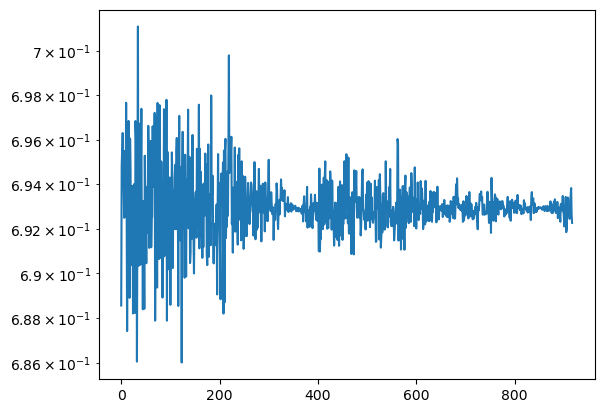

In [96]:
# TODO: Plot loss
plt.plot(total_loss[20:])
plt.yscale('log')
print(outputs[10:15].T)
print(labels[10:15].T)


(d)

In [ ]:
# TODO: Evaluate classifier

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# TODO: Compute tpr, fpr, auc_score

In [3]:
# TODO: Plot ROC and SIC curve

# 2) Implementing Transformers with a Transformer

In [ ]:
# TODO: Ask chatGPT for multi-headed self-attention